# Intensity and spatial features from CSLs for VAE_all

## Extract features for all experiments of the perturbation dataset
```
scripts/extract_features_VAE_all.sh
```

This extracts:
- per cluster mean intensity feature
- per cluster pair co-occurence scores
    - Co-occurrence scores are extracted with logarithmically growing distances, with 20 intervals, up to the maximum distance of 80 pixels
- per cluster and connected component statistics
    - computed statistics are: area, circularity, extent and elongation

The features are saved in an anndata object per data directory:
- `features.h5ad` containing features using the original clustering
- `features_annotation.h5ad` containing features using the annotated clustering

Note that the calculation of co-occurrence scores is time and memory intensive. 
You can adjust the CO_OCC_CHUNK_SIZE value if the processes runs out of memory, and run the feature extraction with multiple processes to speed the computation up.

## Export calculated features as csv
To extract a csv of mean intensity and size features and other metadata columns, execute the following code:

```python
from campa.tl import Experiment, FeatureExtractor
import os

exp = Experiment.from_dir('VAE_all/CondVAE_pert-CC')
for data_dir in exp.data_params['data_dirs']:
    # clusters
    extr = FeatureExtractor.from_adata(os.path.join(exp.full_path, 'aggregated/full_data', data_dir, 'features.h5ad'))
    extr.extract_intensity_csv(obs=['well_name', 'perturbation_duration', 'TR'])

    # annotated clusters
    extr = FeatureExtractor.from_adata(os.path.join(exp.full_path, 'aggregated/full_data', data_dir, 'features_annotation.h5ad'))
    extr.extract_intensity_csv(obs=['well_name', 'perturbation_duration', 'TR'])
```

# Explore features
In the following, we plot intensity, co-occurence, and object features using plotting function provided in campa.pl

We use `features_annotation.h5ad`, for plotting results on the original clustering, replace this with `features.h5ad`

In [1]:
from campa.tl import Experiment, FeatureExtractor
import os
from campa.pl import plot_mean_intensity, get_intensity_change, plot_intensity_change, plot_mean_size, plot_size_change, plot_object_stats
from campa.pl import plot_co_occurrence, plot_co_occurrence_grid
import anndata as ad
from campa.utils import init_logging
import logging
init_logging(level=logging.WARNING)

In [2]:
exp = Experiment.from_dir('VAE_all/CondVAE_pert-CC')
features_fname = 'features_annotation.h5ad'

# load extracted features for clustering_res0.5, annotation
extrs = [FeatureExtractor.from_adata(os.path.join(exp.full_path, 'aggregated/full_data', data_dir, features_fname)) for data_dir in exp.data_params['data_dirs']]


## Mean and per cluster intensity

In [3]:
# get combined adata for dotplots
adatas = [extr.get_intensity_adata() for extr in extrs]
adata = ad.concat(adatas, index_unique='-')

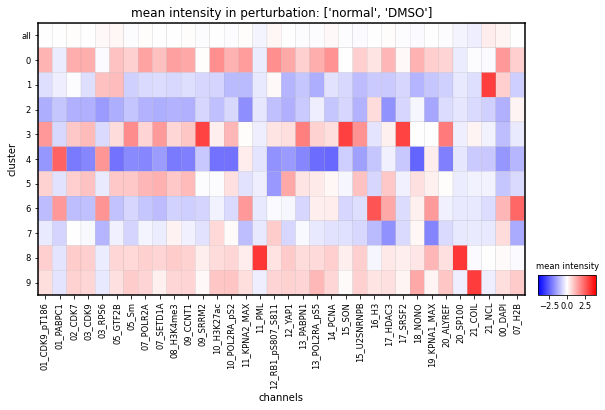

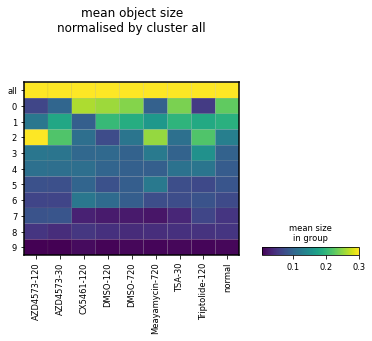

In [4]:
plot_mean_intensity(adata, groupby='cluster', limit_to_groups={'perturbation':['normal', 'DMSO']}, dendrogram=False, layer=None, 
    standard_scale='var', cmap='bwr', vmin=-4, vmax=4)
plot_mean_size(adata, groupby_row='cluster', groupby_col='perturbation_duration', normby_row='all', vmax=0.3)

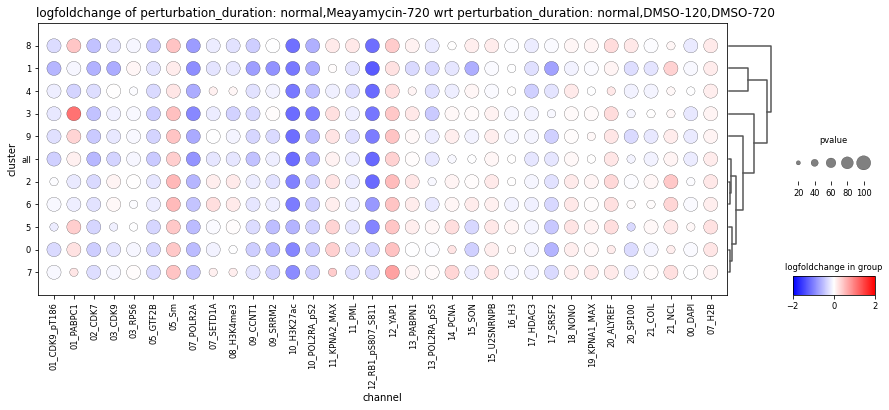

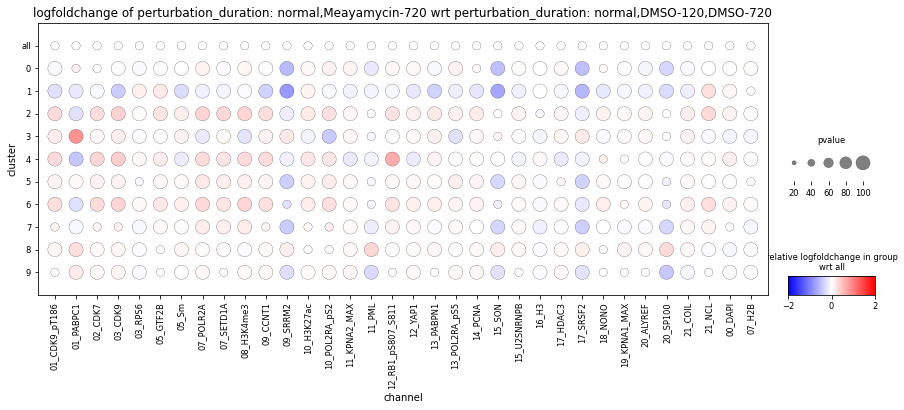

In [11]:
res = get_intensity_change(adata, groupby='cluster', reference_group='perturbation_duration', reference=['normal','DMSO-120', 'DMSO-720'], 
    limit_to_groups={'perturbation_duration': ['normal', 'Meayamycin-720']}, color='logfoldchange', size='pval')
plot_intensity_change(**res, adjust_height=True, figsize=(15,5), vmin=-2, vmax=2, dendrogram=True)

res = get_intensity_change(adata, groupby='cluster', reference_group='perturbation_duration', reference=['normal','DMSO-120', 'DMSO-720'], 
    limit_to_groups={'perturbation_duration': ['normal', 'Meayamycin-720']}, color='logfoldchange', size='pval', norm_by_group='all')
plot_intensity_change(**res, adjust_height=True, figsize=(15,5), vmin=-2, vmax=2)

## Co-occurrence scores

In [8]:
# get combined adata for co-occurrence
adata_co_occ = ad.concat([extr.adata for extr in extrs], index_unique='-', uns_merge='same')

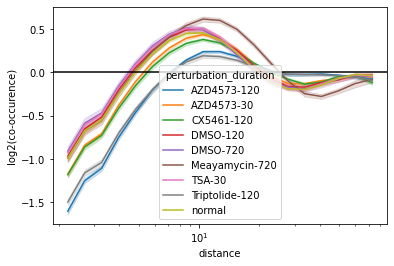

In [16]:
# for one cluster-cluster pairing
plot_co_occurrence(adata_co_occ, 'Nuclear speckles', 'PML bodies', 'perturbation_duration', condition_values=None)

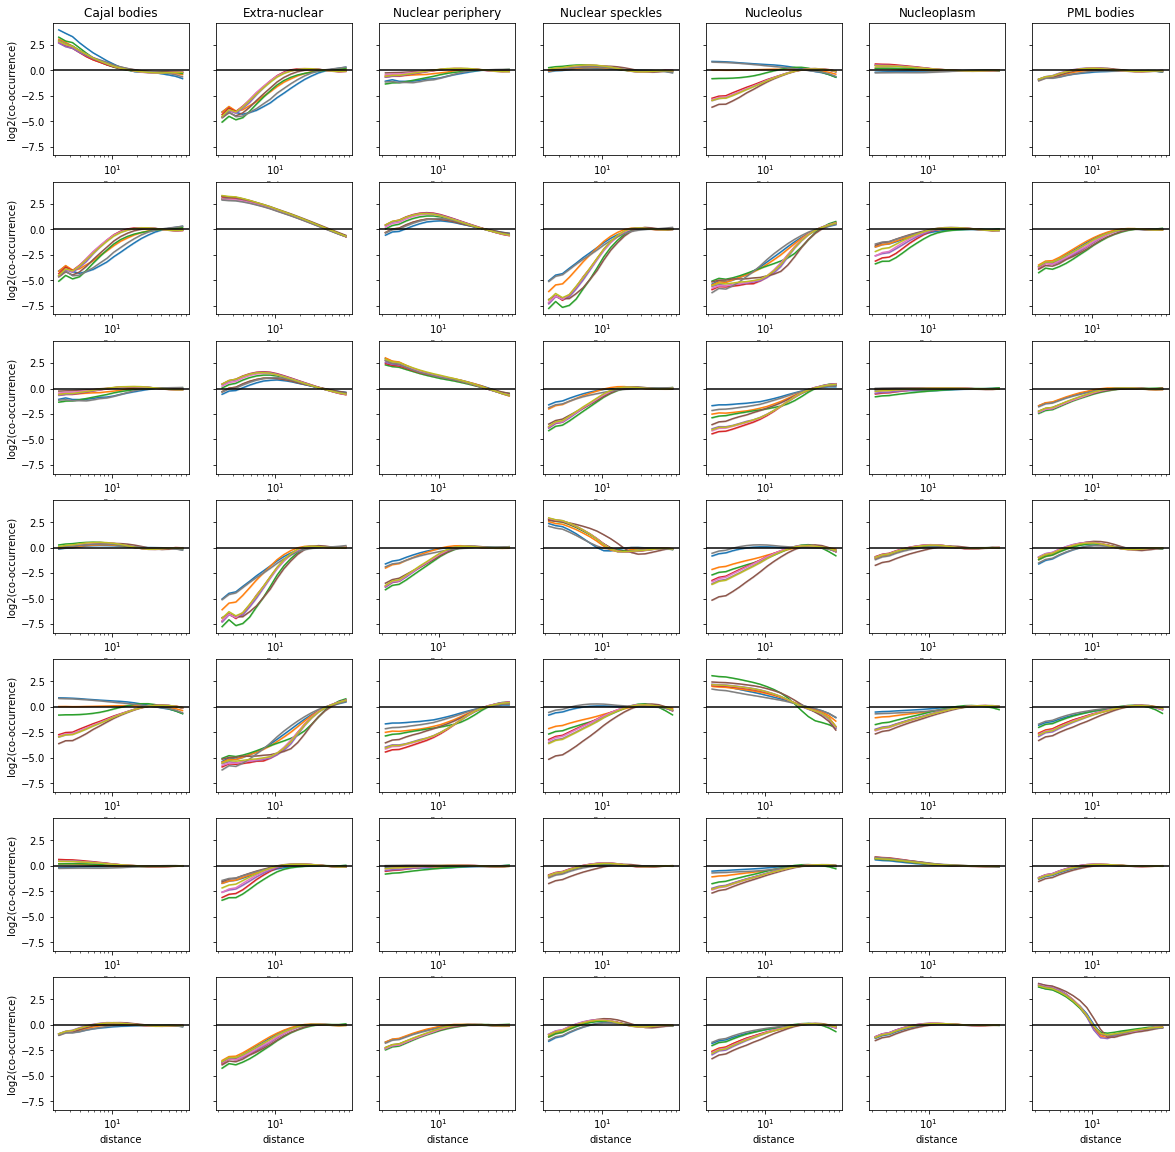

In [17]:
# for all cluster pairings
fig, axes = plot_co_occurrence_grid(adata_co_occ, 'perturbation_duration', condition_values=None, legend=False, ci=False, figsize=(20,20))

## Object statistics

In [ ]:
# aggregate object statistics
for extr in extrs:
    _ = extr.get_object_stats(area_threshold=10, agg=['median'])
# combined adatas for plotting
adata_object_stats = ad.concat([extr.adata for extr in extrs], index_unique='-', uns_merge='same')


In [ ]:
plot_object_stats(adata_object_stats, group_key='perturbation_duration')

# Old / devel: checking if co-occ scores contain nans
- yes, below is for VAE_all. Several mapboect ids only contain Nans for co-occ scores.
- 

In [32]:
import pandas as pd
for c1 in extrs[0].clusters:
    for c2 in extrs[0].clusters:
        if pd.isna(adata_co_occ.obsm[f'co_occurrence_{c1}_{c2}']).any(axis=1).any():
            print(c1, c2)
            print(np.where(pd.isna(adata_co_occ.obsm[f'co_occurrence_{c1}_{c2}']).all(axis=1)))
            ids = adata_co_occ.obs['mapobject_id'][pd.isna(adata_co_occ.obsm[f'co_occurrence_{c1}_{c2}']).all(axis=1)]

Cajal bodies Cajal bodies
(array([  111,   118,   157,   167,   252,   276,   374,   431,   563,
         681,   857,   948,   988,  1014,  1121,  1319,  1362,  1368,
        1594,  1669,  1829,  1845,  2014,  2105,  2128,  2138,  2228,
        2342,  2363,  2852,  2904,  3160,  3354,  3553,  3689,  3695,
        3700,  3702,  3715,  3843,  3893,  4001,  4089,  4096,  4137,
        4170,  4179,  4200,  4275,  4389,  4419,  4701,  4734,  5019,
        5024,  5142,  5250,  5328,  5344,  5352,  5377,  5404,  5496,
        5537,  5547,  5556,  5589,  5632,  5672,  5675,  5677,  5807,
        5809,  5968,  6018,  6100,  6130,  6212,  6240,  6243,  6528,
        6624,  6688,  6832,  6878,  6910,  7021,  7054,  7261,  7311,
        7388,  7479,  7612,  7765,  7828,  7943,  7948,  7975,  8190,
        8235,  8278,  8393,  8573,  8700,  9053,  9250,  9325,  9436,
        9483,  9601,  9680,  9699,  9714,  9963, 10146, 10164, 10755,
       10788, 11116, 11128, 11138, 11172, 11186, 11188, 11199, 

In [36]:
print(list(ids))

['248093', '256547', '259775', '259788', '281060', '291044', '345899', '359180', '203583', '228655', '277467', '332315', '337373', '337409', '378252', '249462', '259957', '259966', '321052', '340081', '363281', '379464', '202871', '251487', '257505', '257519', '268737', '334631', '334658', '313065', '327164', '226929', '287089', '352378', '198155', '198165', '198367', '198370', '198389', '235644', '267963', '301213', '314039', '314049', '328993', '363581', '363595', '367383', '227327', '256164', '264001', '335779', '336427', '232413', '232420', '255528', '272919', '294894', '294922', '300802', '322823', '335680', '379525', '220965', '221391', '221406', '243293', '265444', '285843', '285850', '285854', '306805', '307077', '330927', '347797', '369416', '377157', '201549', '215202', '215205', '285610', '299112', '343000', '200252', '206657', '209493', '266462', '278069', '348919', '379895', '209389', '253034', '292312', '353287', '208851', '231850', '231857', '254667', '347220', '352312',

In [37]:
print(ids.index)

Index(['111-0', '118-0', '157-0', '167-0', '252-0', '276-0', '374-0', '431-0',
       '6-1', '124-1',
       ...
       '214-20', '216-20', '229-20', '275-20', '282-20', '285-20', '291-20',
       '432-20', '433-20', '436-20'],
      dtype='object', length=154)


In [38]:
extrs[0].mpp_data

In [58]:
adata_co_occ[adata_co_occ.obs['mapobject_id'] == '248093'].obsm['co_occurrence_Nucleolus_Nucleolus']

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
111-0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


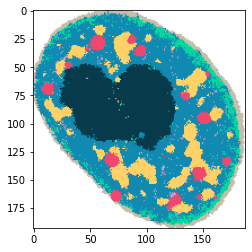

In [51]:
import matplotlib.pyplot as plt


plt.imshow(extrs[0].mpp_data.get_object_img(248093, data='clustering_res0.5', annotation_kwargs={'annotation':extrs[0].annotation, 'to_col':'annotation', 
                                                                                      'color':True})[0])

In [41]:
extrs[0].mpp_data._data.keys()

dict_keys(['x', 'y', 'obj_ids', 'labels', 'mpp', 'clustering_res0.5', 'latent', 'conditions'])